# Neural Networks for Time Series

* Author: Romain Tavenard (@rtavenar)
* License: CC-BY-NC-SA

A notebook from a course on Machine Learning for Time Series at ENSAI.
One can find lecture notes for this course [there](https://rtavenar.github.io/ml4ts_ensai/).


## Preamble

This lab session deals with the use of neural networks for time series classification and forecasting.
Two kinds of architectures are considered here: convolutional and recurrent models.

## Time Series Classification using convolutional models (ConvNets)

For a start, you will load the "Trace" dataset using [`tslearn` data loading tool](https://tslearn.readthedocs.io/en/latest/gen_modules/datasets/tslearn.datasets.CachedDatasets.html#tslearn.datasets.CachedDatasets.load_dataset).

**Question #1.** What are the dimensions of the training data (`X_train`)? And what does each dimension correspond to (number of series, number of timestamps, number of features, ...)?
Also, `keras` expects class information to be encoded as one-hot vectors. Use [`to_categorical`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) to format your `y` arrays accordingly.


In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [2]:
from tslearn.datasets import CachedDatasets

data_loader = CachedDatasets()
X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")
print(X_train.shape)

y_train -= 1
y_test -= 1

print(set(y_train))

(100, 275, 1)
{0, 1, 2, 3}


**Question #2.** In the following, you will be implementing a ConvNet using keras' [`Conv1D`](https://keras.io/api/layers/convolution_layers/convolution1d/) layers.
What value should be passed to the `data_format` parameter to match `tslearn` format? Is it the default value?

The default is `"channels_last"`, which is what we need.

**Question #3.** `keras` has a `Sequential` model class that allows to build models by stacking layers.
Define a model that is made of the following layers (use ReLU activation wherever it makes sense):

* a convolution layer made of 10 filters of size 3
* a pooling layer of pool size 2
* a flatten layer (that converts a time series of features into a flattened array that is suited to feed fully-connected layers)
* a fully-connected layer that has as many neurons as the number of classes in the "Trace" problem, and an adequate activation function.

Compile your model (use "Adam" optimizer) and fit it for 10 epochs.

In [3]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, Flatten, Dense

model = Sequential([
    Conv1D(filters=10, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    Flatten(),
    Dense(units=4, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3384 - loss: 1.3710 - val_accuracy: 0.4200 - val_loss: 1.1645
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6582 - loss: 0.9428 - val_accuracy: 0.4700 - val_loss: 0.9013
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6708 - loss: 0.8046 - val_accuracy: 0.4700 - val_loss: 0.7969
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6590 - loss: 0.7162 - val_accuracy: 0.4700 - val_loss: 0.7875
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6762 - loss: 0.6939 - val_accuracy: 0.4800 - val_loss: 0.8250
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6050 - loss: 0.7214 - val_accuracy: 0.4600 - val_loss: 0.8174
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6072 - loss: 0.6580 - val_accuracy: 0.4500 - val_loss: 0.7716
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6807 - loss: 0.6294 - val_accuracy: 0.4800 - val_loss: 0.7483


**Question #4.** Plot the evolution of accuracy through epochs on both training and validation sets.

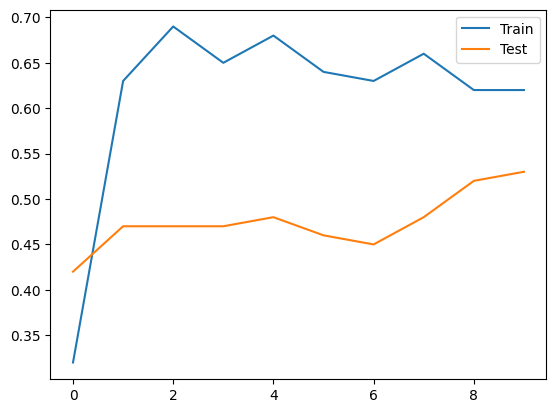

In [4]:
import matplotlib.pyplot as plt

plt.plot(h.history["accuracy"], label="Train")
plt.plot(h.history["val_accuracy"], label="Test")
plt.legend();

**Question #5.** Ten epochs of training might not be sufficient, yet we do not know how many epochs would be necessary for a decent training. Set up early stopping (cf. [this callback](https://keras.io/api/callbacks/early_stopping/)) and see how long it takes before the model stops training.

In [5]:
from keras.callbacks import EarlyStopping

cb = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
    restore_best_weights=True
)
model = Sequential([
    Conv1D(filters=10, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    Conv1D(filters=20, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    Flatten(),
    Dense(units=4, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[cb])

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1256 - loss: 1.4573 - val_accuracy: 0.2800 - val_loss: 1.3243
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3458 - loss: 1.3250 - val_accuracy: 0.5200 - val_loss: 1.2304
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4785 - loss: 1.2160 - val_accuracy: 0.5200 - val_loss: 1.1414
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4166 - loss: 1.1242 - val_accuracy: 0.5000 - val_loss: 1.0549
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5287 - loss: 1.0311 - val_accuracy: 0.4800 - val_loss: 0.9703
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5964 - loss: 0.9453 - val_accuracy: 0.4300 - val_loss: 0.9082
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5592 - loss: 0.8703 - val_accuracy: 0.4300 - val_loss: 0.8627
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5509 - loss: 0.8111 - val_accuracy: 0.4300 - val_loss:

## Recurrent neural nets

For this new part of the lab, we will use the data generated from the function below:

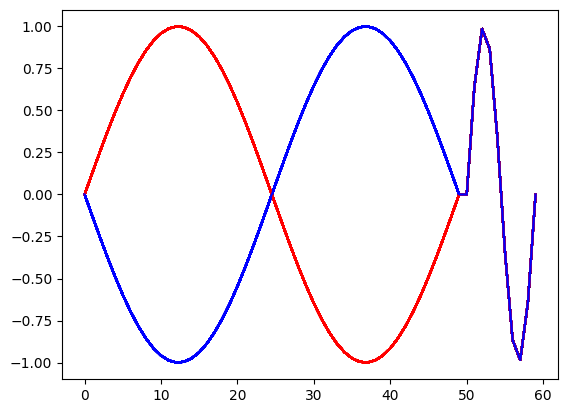

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def make_sines(n_series_per_class, length, length_padding=0):
    t = np.linspace(0, 2 * np.pi, num=length)
    X0 = .005 * np.random.randn(n_series_per_class, length + length_padding)
    X0[:, :length] = np.sin(t).reshape((1, -1))
    X0[:, length:] = np.sin(np.linspace(0, 2 * np.pi, num=length_padding))
    
    X1 = .005 * np.random.randn(n_series_per_class, length + length_padding)
    X1[:, :length] = np.sin(-t).reshape((1, -1))
    X1[:, length:] = np.sin(np.linspace(0, 2 * np.pi, num=length_padding))

    dataset = np.array([X0, X1]).reshape((2 * n_series_per_class, length + length_padding, 1))
    y = np.array([0] * n_series_per_class + [1] * n_series_per_class)

    indices = np.random.permutation(2 * n_series_per_class)
    return dataset[indices], y[indices]

np.random.seed(0)
X, y = make_sines(100, 50, length_padding=10)

plt.figure()
colors = ["r", "b"]
for ts, yi in zip(X, y):
    plt.plot(ts.ravel(), color=colors[yi])
plt.show()

**Question #7.** Implement your own recurrent layer (_cf._ formulas in the course) using the skeleton below and train a network
made of a single recurrent unit with a 8-dimensional hidden state followed by a fully connected layer, and evaluate its classification 
performance on the dataset provided above.

In [7]:
from keras.layers import Layer
from keras.ops import tanh, zeros

class CustomRecurrentUnit(Layer):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

        # List sets of parameters here
        self.w_h = self.add_weight(
            shape=(hidden_dim, hidden_dim), initializer="random_normal", trainable=True
        )
        self.b_h = self.add_weight(shape=(hidden_dim,), initializer="zeros", trainable=True)
        self.w_i = self.add_weight(
            shape=(input_dim, hidden_dim), initializer="random_normal", trainable=True
        )
        self.b_i = self.add_weight(shape=(hidden_dim,), initializer="zeros", trainable=True)
    
    def linear_hidden(self, h_t):
        return h_t @ self.w_h + self.b_h
    
    def linear_input(self, x_t):
        return x_t @ self.w_i + self.b_i
    
    def call(self, x):
        n_timestamps = x.shape[1]
        h = zeros((1, self.hidden_dim))  # Initialize h to [0, ..., 0]
        for t in range(n_timestamps):
            h = tanh(self.linear_hidden(h) + self.linear_input(x[:, t]))
        return h

In [8]:
from keras.callbacks import Callback

class CustomLogging(Callback):
    def __init__(self, every_n_epochs=10):
        super().__init__()
        self.every_n_epochs = every_n_epochs

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.every_n_epochs == self.every_n_epochs - 1:
            # accuracy = self.model.evaluate(*self.training_data)
            print(f"Training loss after epoch {epoch}: {logs['loss']}")

**Question #8.** Implement a network made of a `CustomRecurrentUnit` followed by a fully-connected layer
for the classification task introduced above.
Evaluate this model both in terms of training loss and test-set accuracy (you can use the above callback to limit the amount of logging).

In [9]:
X, y = make_sines(100, 50, length_padding=5)
X_test, y_test = make_sines(100, 50, length_padding=5)

model = Sequential([
    CustomRecurrentUnit(input_dim=1, hidden_dim=100),
    Dense(units=1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X, y, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4648 - loss: 0.6958 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4982 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6865
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6285 - loss: 0.6495 - val_accuracy: 1.0000 - val_loss: 0.3507
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.2574 - val_accuracy: 1.0000 - val_loss: 0.0385
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0242 - val_accuracy: 1.0000 - val_loss: 0.0064
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss:

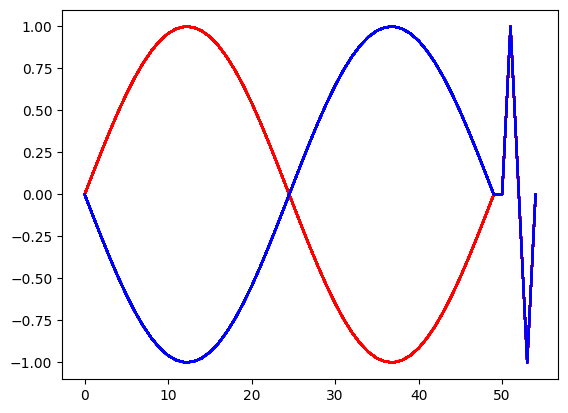

In [10]:
plt.figure()
colors = ["r", "b"]
for ts, yi in zip(X, y):
    plt.plot(ts.ravel(), color=colors[yi])
plt.show()

**Question #9.** Update your dataset so that it includes a final padding of 15 timestamps (_cf._ signature of the `make_sines` function)
and see how it impacts performance of your model.

In [11]:
X, y = make_sines(100, 50, length_padding=25)
X_test, y_test = make_sines(100, 50, length_padding=25)

model = Sequential([
    CustomRecurrentUnit(input_dim=1, hidden_dim=100),
    Dense(units=1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X, y, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4910 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4571 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5465 - loss: 0.6917 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5191 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5070 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5131 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4982 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4983 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss:

**Question #10.** Build GRU (resp. LSTM) counterparts of the RNN-based model above.
How do they compare experimentally to the previous model?

In [ ]:
from keras.layers import LSTM

X, y = make_sines(100, 50, length_padding=25)
X_test, y_test = make_sines(100, 50, length_padding=25)

model = Sequential([
    LSTM(units=100),
    Dense(units=1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X, y, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10


/Users/rtavenar/py3.10_ml/lib/python3.10/site-packages/keras/src/backend/torch/linalg.py:53: UserWarning: The operator 'aten::linalg_qr.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch.linalg.qr(x, mode=mode)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.5353 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6944
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.4952 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.5059 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.5236 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.5031 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.5212 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.4133 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.4712 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6933
Epo

In [ ]:
from keras.layers import GRU, GlobalMaxPooling1D, Flatten

model = Sequential([
    GRU(units=100),
    Flatten(),
    Dense(units=1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X, y, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - accuracy: 1.0000 - loss: 0.5604 - val_accuracy: 1.0000 - val_loss: 0.4751
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - accuracy: 1.0000 - loss: 0.4530 - val_accuracy: 1.0000 - val_loss: 0.3827
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - accuracy: 1.0000 - loss: 0.3635 - val_accuracy: 1.0000 - val_loss: 0.3023
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - accuracy: 1.0000 - loss: 0.2873 - val_accuracy: 1.0000 - val_loss: 0.2353
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - accuracy: 1.0000 - loss: 0.2222 - val_accuracy: 1.0000 - val_loss: 0.1812
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - accuracy: 1.0000 - loss: 0.1712 - val_accuracy: 1.0000 - val_loss: 0.1390
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - accuracy: 1.0000 - loss: 0.1312 - val_accuracy: 1.0000 - val_loss: 0.1070
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - accuracy: 1.0000 - loss: 0.1010 - val_accuracy: 1.0000 - val_loss:

## Recap

**Question #11.** Come back to the "Trace" dataset used above and design a fair comparison between several convolutional and recurrent architectures to decide which one to choose for the problem at hand (feel free to play with the depth of the nets, as well as hidden representation dimensionality, etc.).

In [14]:
from tslearn.datasets import CachedDatasets

data_loader = CachedDatasets()
X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")
print(X_train.shape)

y_train -= 1
y_test -= 1


feature_extractors = {
    "Conv_1layer": Sequential([
        Conv1D(filters=25, kernel_size=5, activation="relu")
    ]),
    "Conv_2layers": Sequential([
        Conv1D(filters=25, kernel_size=5, activation="relu"),
        Conv1D(filters=25, kernel_size=5, activation="relu"),
    ]),
    "Conv_3layers": Sequential([
        Conv1D(filters=25, kernel_size=5, activation="relu"),
        Conv1D(filters=25, kernel_size=5, activation="relu"),
        Conv1D(filters=25, kernel_size=5, activation="relu"),
    ]),
    "LSTM_1layer": Sequential([
        LSTM(units=25, return_sequences=True)
    ]),
    "LSTM_2layers": Sequential([
        LSTM(units=25, return_sequences=True),
        LSTM(units=25, return_sequences=True),
    ]),
    "LSTM_3layers": Sequential([
        LSTM(units=25, return_sequences=True),
        LSTM(units=25, return_sequences=True),
        LSTM(units=25, return_sequences=True)
    ]),
}

for name, f in feature_extractors.items():
    model = Sequential([
        f,
        Flatten(),
        Dense(units=4, activation="softmax")
    ])
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    h = model.fit(X_train, y_train, epochs=10, verbose=False)
    print(name, model.evaluate(X_test, y_test))

(100, 275, 1)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5330 - loss: 0.7330
Conv_1layer [0.7093221545219421, 0.5799999833106995]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5080 - loss: 0.8395
Conv_2layers [0.8022701144218445, 0.5199999809265137]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5414 - loss: 0.7075
Conv_3layers [0.6876100301742554, 0.5799999833106995]
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.4773 - loss: 0.7790
LSTM_1layer [0.7508528232574463, 0.49000000953674316]
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.4300 - loss: 0.7730
LSTM_2layers [0.7715491652488708, 0.44999998807907104]
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step - accuracy: 0.4297 - loss: 0.8036
LSTM_3layers [0.7814050912857056, 0.4699999988079071]


# Bonus: visualizing feature importance

An important topic in machine learning is interpretability, which is about explaining model-based decisions.
Regarding neural networks, a large body of the interpretability litterature relies on showing which parts of the input data is most important for a decision.

A way to visualize the importance of input features on a given decision is to compute gradients of the model's output with respect to its input.

The function below does it:

In [15]:
import torch

def make_gradient_heatmap(batch_of_time_series, model):
    inputs = torch.tensor(batch_of_time_series, dtype=torch.float32, requires_grad=True)

    preds = model(inputs)
    output_channel = preds[:, 0]

    model.zero_grad()
    output_channel.backward(torch.ones_like(output_channel))

    grads = inputs.grad.abs()
    grads = grads / grads.max(dim=1, keepdim=True)[0]

    return grads.detach().numpy()

**Question #12.** Getting back to the binary decision problem with padded sines, visualize the importance of input features in the final decision for:
* a network with one LSTM layer
* a network with one convolutional layer

In [22]:
X, y = make_sines(100, 50, length_padding=25)

rec_model = Sequential([
    LSTM(units=25),
    Flatten(),
    Dense(units=1, activation="sigmoid")
])
rec_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
h = rec_model.fit(X, y, epochs=200, verbose=0)

conv_model = Sequential([
    Conv1D(filters=25, kernel_size=5),
    Flatten(),
    Dense(units=1, activation="sigmoid")
])
conv_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
h = conv_model.fit(X, y, epochs=200, verbose=0)

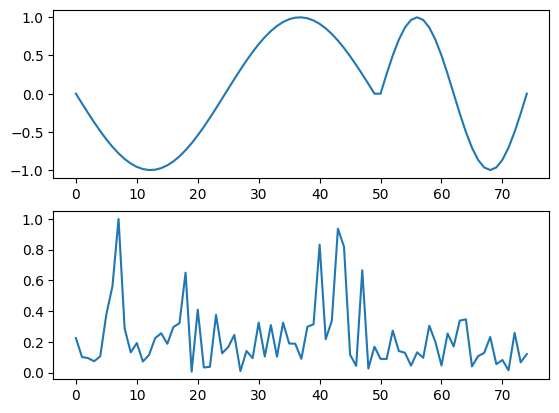

In [23]:
grads = make_gradient_heatmap(X, conv_model)

plt.subplot(2, 1, 1)
plt.plot(X[0, :, 0])
plt.subplot(2, 1, 2)
plt.plot(grads[0, :, 0])

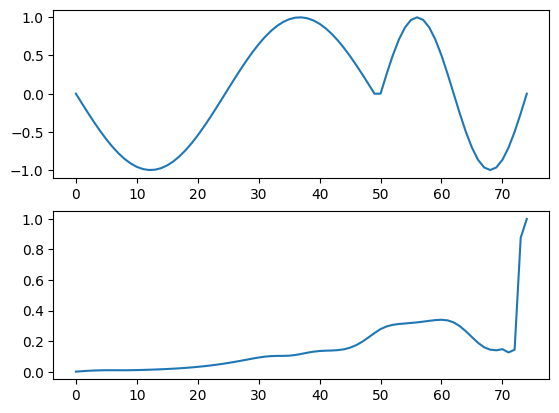

In [24]:
grads = make_gradient_heatmap(X, rec_model)

plt.subplot(2, 1, 1)
plt.plot(X[0, :, 0])
plt.subplot(2, 1, 2)
plt.plot(grads[0, :, 0])